## Prep

In [1]:
import tensorflow as tf

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True


In [1]:
# These are my default settings
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import joblib

plt.rcParams["figure.figsize"] = (12, 6)
sns.set()
pd.set_option("display.max_columns", None)

import zipfile
import shutil

In [4]:
import itertools
import os

import tensorflow as tf

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.10.0
GPU is available


### unzip data

In [4]:
shutil.unpack_archive('MedNIST Train Data.zip')

In [5]:
data_dir = "./MedNIST Training Dataset"

In [6]:
# setting get image

BATCH_SIZE = 1024
IMAGE_SIZE = (64, 64)

train_size = 0.8
valid_size = 0.2

RANDOM_STATE = 42

## Check images

In [7]:
# import PIL

# # get label names
# class_names = sorted(x for x in os.listdir(data_dir)
#                      if os.path.isdir(os.path.join(data_dir, x)))

# num_class = len(class_names)
# image_files = [
#     [
#         os.path.join(data_dir, class_names[i], x)
#         for x in os.listdir(os.path.join(data_dir, class_names[i]))
#     ]
#     for i in range(num_class)
# ]
# num_each = [len(image_files[i]) for i in range(num_class)]


# image_files_list = []
# image_class = []
# for i in range(num_class):
#     image_files_list.extend(image_files[i])
#     image_class.extend([i] * num_each[i])
    
# num_total = len(image_class)
# image_width, image_height = PIL.Image.open(image_files_list[0]).size



# print(f"Total image count: {num_total}")
# print(f"Image dimensions: {image_width} x {image_height}")
# print(f"Label names: {class_names}")
# print(f"Label counts: {num_each}")

In [8]:
# plt.subplots(3, 3, figsize=(8, 8))
# for i, k in enumerate(np.random.randint(num_total, size=9)):
#     im = PIL.Image.open(image_files_list[k])
#     arr = np.array(im)
#     plt.subplot(3, 3, i + 1)
#     plt.xlabel(class_names[image_class[k]])
#     plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
# plt.tight_layout()
# plt.show()

## Get images (first execution only)

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

In [10]:
train_data = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=RANDOM_STATE,
    image_size=IMAGE_SIZE,
    batch_size=2048
)

Found 47169 files belonging to 6 classes.
Using 37736 files for training.


In [11]:
validation_data = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=RANDOM_STATE,
    image_size=IMAGE_SIZE,
    batch_size=2048
)

Found 47169 files belonging to 6 classes.
Using 9433 files for validation.


In [12]:
CLASS_NAMES = train_data.class_names
CLASS_NAMES

['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

## Preprocessing

In [13]:
from tensorflow.keras.layers import Rescaling, Dense, Input
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [14]:
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [15]:
normalized_val = validation_data.map(lambda x, y: (normalization_layer(x), y))

In [16]:
len(CLASS_NAMES)

6

In [17]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

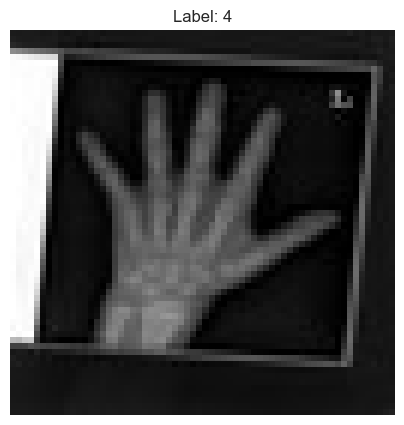

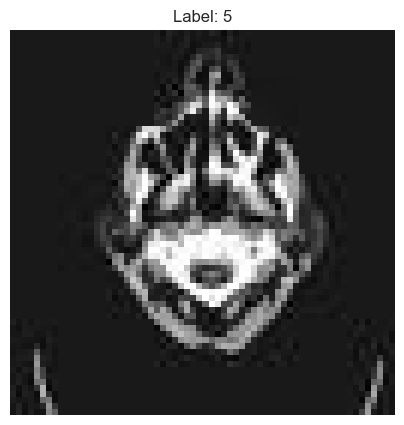

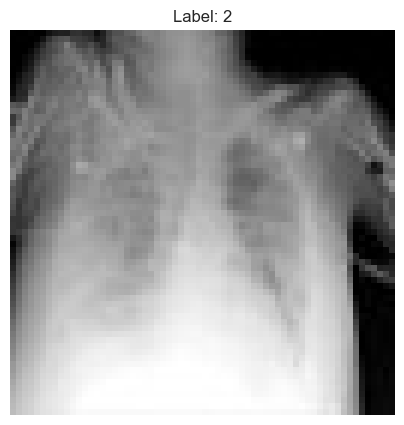

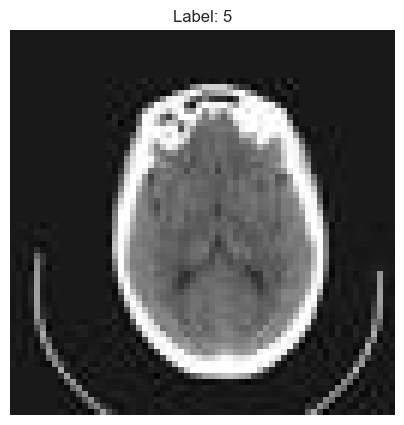

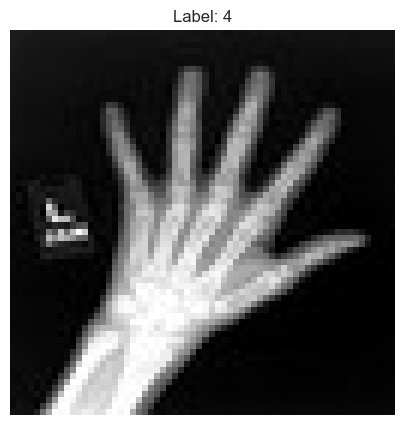

In [18]:
for images, labels in normalized_ds.take(1):
    
    for i in range(5):
        
        plt.figure(figsize=(5,5))
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
        plt.show()

## Simple CNN

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

num_classes = len(CLASS_NAMES)

model = Sequential([
    Conv2D(filters=16, kernel_size=3, strides=1, activation="relu", input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=num_classes, activation="softmax")
])

In [22]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics="accuracy"
)

In [23]:
history = model.fit(
    normalized_ds,
    validation_data=normalized_val,
    epochs=20,
    batch_size = 1024
)

Epoch 1/20
19/19 [==============================] - 17s 281ms/step - loss: 0.6208 - accuracy: 0.8114 - val_loss: 0.2362 - val_accuracy: 0.8959
Epoch 2/20
19/19 [==============================] - 8s 304ms/step - loss: 0.1270 - accuracy: 0.9586 - val_loss: 0.0631 - val_accuracy: 0.9908
Epoch 3/20
19/19 [==============================] - 9s 324ms/step - loss: 0.0438 - accuracy: 0.9922 - val_loss: 0.0277 - val_accuracy: 0.9952
Epoch 4/20
19/19 [==============================] - 8s 317ms/step - loss: 0.0209 - accuracy: 0.9955 - val_loss: 0.0168 - val_accuracy: 0.9960
Epoch 5/20
19/19 [==============================] - 9s 315ms/step - loss: 0.0139 - accuracy: 0.9970 - val_loss: 0.0115 - val_accuracy: 0.9972
Epoch 6/20
19/19 [==============================] - 9s 321ms/step - loss: 0.0087 - accuracy: 0.9978 - val_loss: 0.0083 - val_accuracy: 0.9984
Epoch 7/20
19/19 [==============================] - 9s 321ms/step - loss: 0.0069 - accuracy: 0.9984 - val_loss: 0.0062 - val_accuracy: 0.9988
Epoch

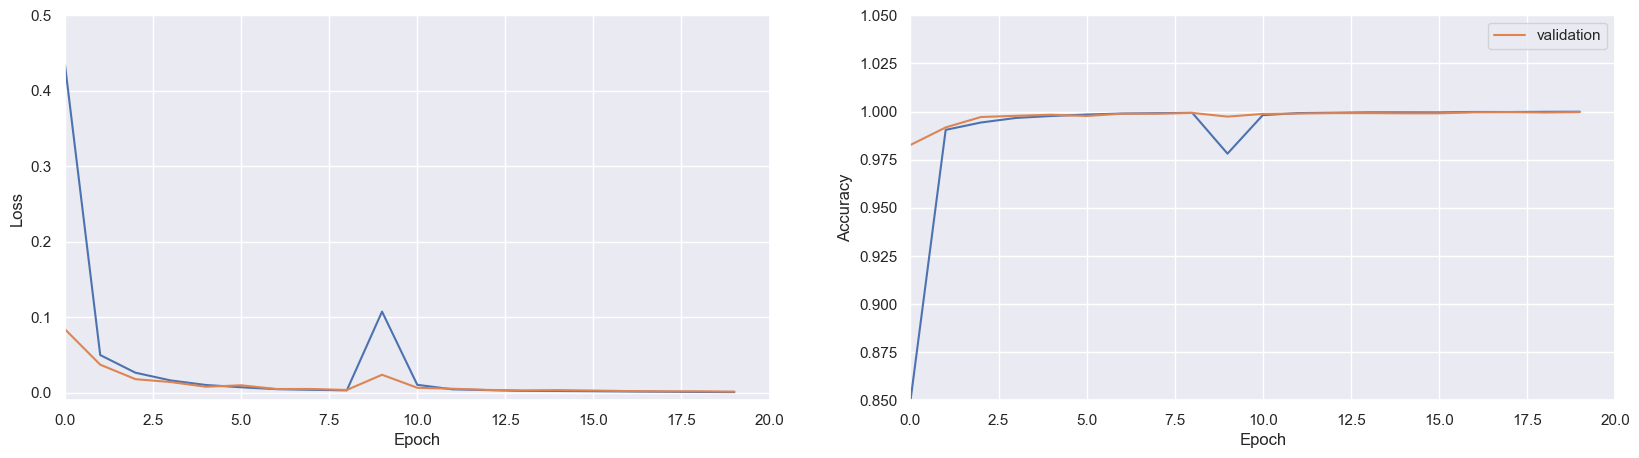

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))  # make 2 subplots

# subplot for loss
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'], label="validation")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_xlim(0, 20)
ax[0].set_ylim(-0.01, 0.5)

# subplot for acc
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'], label="validation")
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlim(0, 20)
ax[1].set_ylim(0.85, 1.05)
plt.legend()
plt.show()

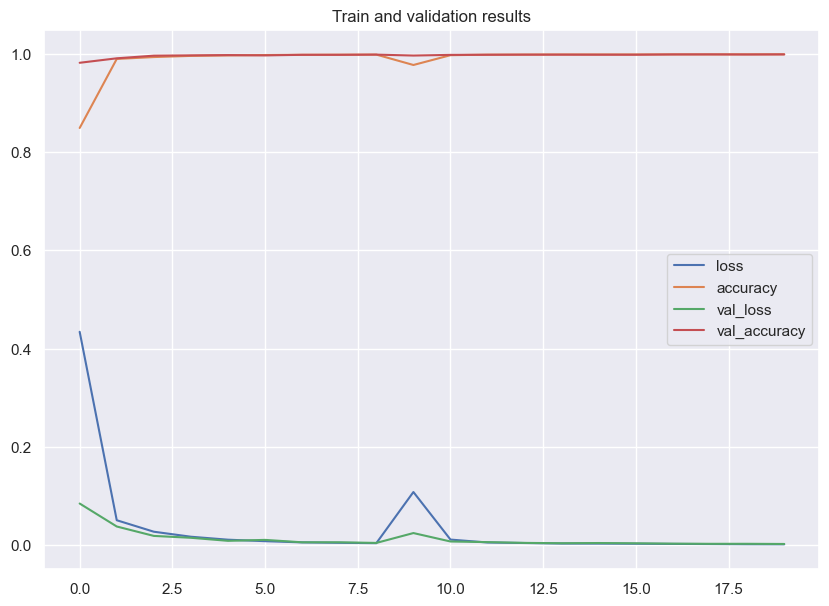

In [53]:
pd.DataFrame(history.history).plot(title="Train and validation results",figsize=(10,7));

## Evalation

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

val_images, val_labels = next(iter(normalized_val))

predictions = model.predict(val_images)
predicted_labels = np.argmax(predictions, axis=1)


print(classification_report(val_labels, predicted_labels, target_names=CLASS_NAMES))


print(confusion_matrix(val_labels, predicted_labels))

64/64 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00       346
   BreastMRI       1.00      1.00      1.00       292
         CXR       1.00      1.00      1.00       366
     ChestCT       1.00      1.00      1.00       344
        Hand       1.00      1.00      1.00       359
      HeadCT       1.00      1.00      1.00       341

    accuracy                           1.00      2048
   macro avg       1.00      1.00      1.00      2048
weighted avg       1.00      1.00      1.00      2048

[[346   0   0   0   0   0]
 [  0 292   0   0   0   0]
 [  0   0 366   0   0   0]
 [  0   0   0 344   0   0]
 [  0   0   0   0 359   0]
 [  0   0   0   0   1 340]]


<Axes: >

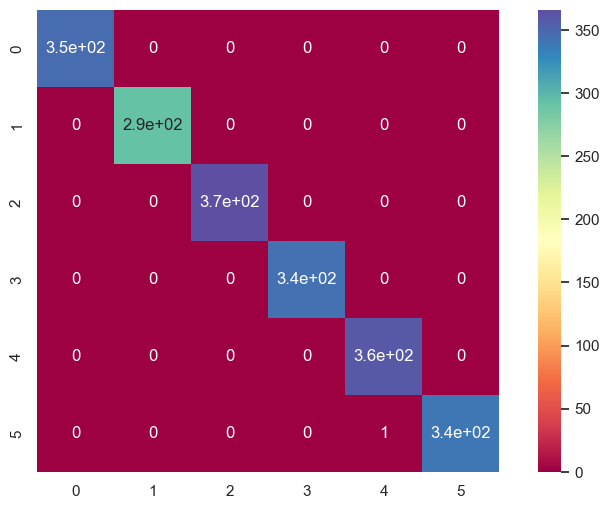

In [28]:
cm = confusion_matrix(val_labels, predicted_labels)
sns.heatmap(cm, square=True, annot=True, cmap="Spectral")

# Save model

In [30]:
model.save("cnn_model")

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets


### zip data

In [2]:
shutil.make_archive('MedNIST Train Data', format='zip', root_dir='MedNIST Training Dataset')

'C:\\Users\\redoa\\workspace\\projects\\mednist\\MedNIST Train Data.zip'

In [3]:
shutil.rmtree("Mednist")

# Extea efficientnet

In [26]:
# # Convert 64x64 images into 224*224
# resized_dataset = image_dataset.map(lambda X, y: (tf.image.resize(X, [244, 244]), y))
# resized_dataset

In [27]:
# from sklearn.model_selection import StratifiedShuffleSplit

# # Use list comprehension to convert images and labels to numpy arrays
# # class_name = resized_dataset.class_names
# X = [img for batch in list(resized_dataset.as_numpy_iterator()) for img in batch[0]]
# y = [label for batch in list(resized_dataset.as_numpy_iterator()) for label in batch[1]]

# images = np.asarray(X)
# labels = np.asarray(y)

In [28]:
# print(type(images), type(labels))

In [29]:
# np.save("./save_file/images", images)
# np.save("./save_file/labels", labels)

## Load Processed Data (after 2nd executions)

In [30]:
# images = np.load("./save_file/images.npy")
# labels = np.load("./save_file/labels.npy")

# print(images.shape, labels.shape)

## Data split

In [31]:
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(images, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels)

In [32]:
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)

# for train_index, valid_index in split.split(images, labels):
#     X_train, X_valid = images[train_index], images[valid_index]
#     y_train, y_valid = labels[train_index], labels[valid_index]

In [33]:
# print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

In [34]:
# take data and labels lists

# image_class_names = image_dataset.class_names
# img_X = []
# img_y = []
# for img_ds_batch in list(image_dataset.as_numpy_iterator()):
#     img_X.extend(img_ds_batch[0])
#     img_y.extend(img_ds_batch[1])

# img_X = np.asarray(img_X)
# img_y = np.asarray(img_y)

# or
# class_name = image_dataset.class_names
# X = [img for batch in list(image_dataset.as_numpy_iterator()) for img in batch[0]]
# y = [label for batch in list(image_dataset.as_numpy_iterator()) for label in batch[1]]

# X_np = np.asarray(X)
# y_np = np.asarray(y)


In [35]:
# print(X_np.shape, y_np.shape)

In [36]:
# print(img_X.shape, img_y.shape)

In [37]:
# Distribution check

# Calculate the sizes of each split
# train_size = len(X_train) / len(images)
# valid_size = len(X_valid) / len(images)

# Create a pie chart
# plt.figure(figsize=(6, 6))
# plt.pie([train_size, valid_size], labels=["Train", "Validation"], autopct='%1.1f%%')
# plt.title('Data Split')
# plt.show()

In [38]:
# # Labels distribution ckeck

# # Calculate the class proportions for each dataset
# train_counts = np.bincount(y_train)
# valid_counts = np.bincount(y_valid)


# # Normalize the counts to get proportions
# train_props = train_counts / len(y_train)
# valid_props = valid_counts / len(y_valid)

# # Create a bar chart
# labels = range(len(train_counts))  
# x = np.arange(len(labels))
# width = 0.2

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width, train_props, width, label='Train')
# rects2 = ax.bar(x, valid_props, width, label='Validation')

# ax.set_ylabel("Proportion")
# ax.set_xlabel("Classes")
# ax.set_title("Label distribution")
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()
# ax.set_ylim(0.14, 0.18)
# fig.tight_layout()
# plt.show()


In [39]:
# from tensorflow.keras.utils import to_categorical

# num_classes = 6

# y_train_preprocessed = to_categorical(y_train, num_classes)
# y_valid_preprocessed = to_categorical(y_valid, num_classes)


In [40]:
NUM_CLASSES = len(labels)
NUM_CLASSES

1024

## Model

In [41]:
# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetV2B0
# from tensorflow.keras import layers, Input, Model
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.losses import sparse_categorical_crossentropy as SCC


In [42]:
# base_model = EfficientNetV2B0(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(224,224,3),
# )

# base_model.trainable = False

In [43]:
# inputs = Input(shape=(224,224,3))
# x = base_model(inputs, training=False)

# outputs = Dense(NUM_CLASSES)(x)

# model = Model(inputs, outputs)

In [44]:
# model.summary()

## Compile

In [45]:
# model.compile(
#     optimizer="adam",
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )

In [46]:
# model.fit(
#     x=X_train,
#     y=y_train,
#     batch_size=512
#     # validation_data=(X_valid, y_valid),
# )
# #

In [47]:
# X_train_predixted = model.predict(X_train)
# X_valid_predicted = model.predict(X_valid)